# 4. Top-N Simulations from Actual Experimental Data

This notebook loads an existing Beer1pos data, runs it through the simulator and compares the simulated results to the initial input data. The results here correspond to Section 3.2 in the paper.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pylab as plt
import pymzml

In [3]:
import sys
sys.path.append('../..')

In [4]:
from vimms.Roi import RoiToChemicalCreator, make_roi
from vimms.DataGenerator import DataSource, PeakSampler, get_spectral_feature_database
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController
from vimms.Environment import Environment

from vimms.PlotsForPaper import count_stuff, plot_num_scans, match_peaklist, check_found_matches, \
plot_matched_intensities, plot_matched_precursors
from vimms.Common import *

In [5]:
set_log_level_debug()

## 1. Parameters

In [6]:
base_dir = 'example_data'
mzml_path = os.path.join(base_dir, 'beers', 'fragmentation', 'mzML')
file_name = 'Beer_multibeers_1_T10_POS.mzML'

experiment_name = 'mzml_compare'
experiment_out_dir = os.path.join(base_dir, 'results', experiment_name)

In [7]:
min_rt = 0
max_rt = 1441

In [8]:
kde_min_ms1_intensity = 0 # min intensity to be selected for kdes
kde_min_ms2_intensity = 0

### a. ROI extraction parameters

In [9]:
roi_mz_tol = 10
roi_min_length = 1
roi_min_intensity = 0
roi_start_rt = min_rt
roi_stop_rt = max_rt

### b. Top-N parameters

In [10]:
isolation_width = 1   # the (full) isolation width in Dalton around a selected precursor m/z
ionisation_mode = POSITIVE
N = 10
rt_tol = 15
mz_tol = 10
min_ms1_intensity = 1.75E5 # minimum ms1 intensity to fragment

In [11]:
mzml_filename = 'simulated.mzML'
mzml_out = os.path.join(experiment_out_dir, mzml_filename)

## 2. Train densities

In [12]:
ds = DataSource()
ds.load_data(mzml_path, file_name=file_name)

2019-12-12 11:42:02.439 | INFO     | vimms.DataGenerator:load_data:161 - Loading Beer_multibeers_1_T10_POS.mzML


In [13]:
bandwidth_mz_intensity_rt=1.0
bandwidth_n_peaks=1.0
ps = get_spectral_feature_database(ds, file_name, kde_min_ms1_intensity, kde_min_ms2_intensity, min_rt, max_rt,
               bandwidth_mz_intensity_rt, bandwidth_n_peaks)

2019-12-12 11:42:10.479 | DEBUG    | vimms.DataGenerator:__init__:436 - Extracted 7647 MS2 scans
2019-12-12 11:42:10.480 | DEBUG    | vimms.DataGenerator:_compute_intensity_props:614 - Computing parent intensity proportions
2019-12-12 11:42:11.346 | DEBUG    | vimms.DataGenerator:__init__:445 - Extracting scan durations
2019-12-12 11:42:11.347 | DEBUG    | vimms.DataGenerator:_kde:626 - Training KDEs for ms_level=1
2019-12-12 11:42:11.347 | DEBUG    | vimms.DataGenerator:_kde:637 - Retrieving mz_intensity_rt values from <vimms.DataGenerator.DataSource object at 0x7f6542c59320>
2019-12-12 11:42:11.348 | INFO     | vimms.DataGenerator:get_data:295 - Using values from scans
2019-12-12 11:42:23.958 | DEBUG    | vimms.DataGenerator:_kde:637 - Retrieving n_peaks values from <vimms.DataGenerator.DataSource object at 0x7f6542c59320>
2019-12-12 11:42:33.160 | DEBUG    | vimms.DataGenerator:_kde:626 - Training KDEs for ms_level=2
2019-12-12 11:42:33.160 | DEBUG    | vimms.DataGenerator:_kde:637 

## 3. Extract all ROIs

In [14]:
mzml_file = os.path.join(mzml_path, file_name)
good_roi, junk = make_roi(mzml_file, mz_tol=roi_mz_tol, mz_units='ppm', min_length=roi_min_length,
                          min_intensity=roi_min_intensity, start_rt=roi_start_rt, stop_rt=roi_stop_rt)

In [15]:
all_roi = good_roi + junk
len(all_roi)

511968

How many singleton and non-singleton ROIs?

In [16]:
len([roi for roi in all_roi if roi.n == 1])

352746

In [17]:
len([roi for roi in all_roi if roi.n > 1])

159222

Keep only the ROIs that can be fragmented above **min_ms1_intensity threshold**.

In [18]:
min_ms1_intensity

175000.0

In [19]:
keep = []
for roi in all_roi:
    if np.count_nonzero(np.array(roi.intensity_list) > min_ms1_intensity) > 0:
        keep.append(roi)

all_roi = keep
len(keep)

10065

Turn ROIs into chromatograms/chemicals

In [20]:
set_log_level_debug()
rtcc = RoiToChemicalCreator(ps, all_roi)

2019-12-12 11:46:06.799 | DEBUG    | vimms.Roi:__init__:314 -      0/ 10065
2019-12-12 11:46:09.710 | INFO     | vimms.Roi:__init__:338 - Found 10065 ROIs above thresholds


In [21]:
data = rtcc.chemicals
save_obj(data, os.path.join(experiment_out_dir, 'dataset.p'))

2019-12-12 11:46:09.724 | INFO     | vimms.Common:create_if_not_exist:48 - Created example_data/results/mzml_compare
2019-12-12 11:46:09.725 | INFO     | vimms.Common:save_obj:61 - Saving <class 'list'> to example_data/results/mzml_compare/dataset.p


## 4. Run Top-N Controller

In [22]:
set_log_level_warning()
pbar = True

In [23]:
mass_spec = IndependentMassSpectrometer(ionisation_mode, data, ps)
controller = TopNController(ionisation_mode, N, isolation_width, mz_tol,
                            rt_tol, min_ms1_intensity)

In [24]:
# create an environment to run both the mass spec and controller
env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)

# set the log level to WARNING so we don't see too many messages when environment is running
set_log_level_warning()

# run the simulation
env.run()

(1441.027s) ms_level=1 N=10 DEW=15: 100%|█████████▉| 1440.7595599999897/1441 [01:51<00:00, 12.90it/s]


In [25]:
set_log_level_debug()
env.write_mzML(experiment_out_dir, mzml_filename)

2019-12-12 11:48:02.836 | DEBUG    | vimms.Environment:write_mzML:142 - Writing mzML file to example_data/results/mzml_compare/simulated.mzML
2019-12-12 11:48:25.106 | DEBUG    | vimms.Environment:write_mzML:149 - mzML file successfully written!


## 5. Compare Results

### Load simulated and real data.

In [26]:
simulated_input_file = mzml_out
simulated_mzs, simulated_rts, simulated_intensities, simulated_cumsum_ms1, simulated_cumsum_ms2 = count_stuff(
    simulated_input_file, min_rt, max_rt)

2019-12-12 11:48:27.612 | DEBUG    | vimms.PlotsForPaper:count_stuff:259 - Number of ms1 scans =
2019-12-12 11:48:27.613 | DEBUG    | vimms.PlotsForPaper:count_stuff:260 - Number of ms2 scans =
2019-12-12 11:48:27.613 | DEBUG    | vimms.PlotsForPaper:count_stuff:261 - Total scans =
2019-12-12 11:48:27.614 | DEBUG    | vimms.PlotsForPaper:count_stuff:262 - Number of selected precursors =


In [27]:
real_input_file = mzml_file
real_mzs, real_rts, real_intensities, real_cumsum_ms1, real_cumsum_ms2 = count_stuff(
    real_input_file, min_rt, max_rt)

2019-12-12 11:48:29.155 | DEBUG    | vimms.PlotsForPaper:count_stuff:259 - Number of ms1 scans =
2019-12-12 11:48:29.156 | DEBUG    | vimms.PlotsForPaper:count_stuff:260 - Number of ms2 scans =
2019-12-12 11:48:29.157 | DEBUG    | vimms.PlotsForPaper:count_stuff:261 - Total scans =
2019-12-12 11:48:29.157 | DEBUG    | vimms.PlotsForPaper:count_stuff:262 - Number of selected precursors =


### Plot number of scans

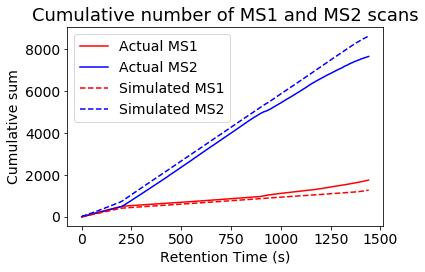

In [28]:
plt.rcParams.update({'font.size': 14})
out_file = os.path.join(base_dir, 'results', 'topN_num_scans.png')
plot_num_scans(real_cumsum_ms1, real_cumsum_ms2, simulated_cumsum_ms1, simulated_cumsum_ms2, out_file)

### Check the number of precursors that could be matched at different m/z and RT tolerances

In [29]:
mz_tol = None # in ppm. if None, then 2 decimal places is used for matching the m/z
rt_tol = 5 # seconds
matches = match_peaklist(real_mzs, real_rts, real_intensities, simulated_mzs, simulated_rts, simulated_intensities, mz_tol, rt_tol)
check_found_matches(matches, 'Real', 'Simulated')

2019-12-12 11:48:29.778 | DEBUG    | vimms.PlotsForPaper:check_found_matches:191 - Found 4788/7655 (0.625474)
2019-12-12 11:48:29.778 | DEBUG    | vimms.PlotsForPaper:check_found_matches:193 - Real						Simulated
2019-12-12 11:48:29.780 | DEBUG    | vimms.PlotsForPaper:check_found_matches:197 - mz 144.98 rt 0.6005 intensity 1548081.2500	mz 144.98 rt 0.5390 intensity 1736415.0255
2019-12-12 11:48:29.780 | DEBUG    | vimms.PlotsForPaper:check_found_matches:197 - mz 207.16 rt 0.7352 intensity 1443976.8750	mz 207.16 rt 0.6790 intensity 1517575.7838
2019-12-12 11:48:29.781 | DEBUG    | vimms.PlotsForPaper:check_found_matches:197 - mz 126.05 rt 0.8693 intensity 1087971.0000	mz 126.05 rt 0.8020 intensity 1325340.9812
2019-12-12 11:48:29.781 | DEBUG    | vimms.PlotsForPaper:check_found_matches:197 - mz 146.98 rt 1.0029 intensity 727259.1875	mz 146.98 rt 0.9320 intensity 809059.0433
2019-12-12 11:48:29.781 | DEBUG    | vimms.PlotsForPaper:check_found_matches:197 - mz 224.19 rt 1.1375 intensity 

In [30]:
mz_tol = None
rt_tol = 10
matches = match_peaklist(real_mzs, real_rts, real_intensities, simulated_mzs, simulated_rts, simulated_intensities, mz_tol, rt_tol)
check_found_matches(matches, 'Real', 'Simulated')

2019-12-12 11:48:29.972 | DEBUG    | vimms.PlotsForPaper:check_found_matches:191 - Found 6537/7655 (0.853952)
2019-12-12 11:48:29.973 | DEBUG    | vimms.PlotsForPaper:check_found_matches:193 - Real						Simulated
2019-12-12 11:48:29.974 | DEBUG    | vimms.PlotsForPaper:check_found_matches:197 - mz 144.98 rt 0.6005 intensity 1548081.2500	mz 144.98 rt 0.5390 intensity 1736415.0255
2019-12-12 11:48:29.975 | DEBUG    | vimms.PlotsForPaper:check_found_matches:197 - mz 207.16 rt 0.7352 intensity 1443976.8750	mz 207.16 rt 0.6790 intensity 1517575.7838
2019-12-12 11:48:29.975 | DEBUG    | vimms.PlotsForPaper:check_found_matches:197 - mz 126.05 rt 0.8693 intensity 1087971.0000	mz 126.05 rt 0.8020 intensity 1325340.9812
2019-12-12 11:48:29.976 | DEBUG    | vimms.PlotsForPaper:check_found_matches:197 - mz 146.98 rt 1.0029 intensity 727259.1875	mz 146.98 rt 0.9320 intensity 809059.0433
2019-12-12 11:48:29.976 | DEBUG    | vimms.PlotsForPaper:check_found_matches:197 - mz 224.19 rt 1.1375 intensity 

In [31]:
mz_tol = None
rt_tol = 15
matches = match_peaklist(real_mzs, real_rts, real_intensities, simulated_mzs, simulated_rts, simulated_intensities, mz_tol, rt_tol)
check_found_matches(matches, 'Real', 'Simulated')

2019-12-12 11:48:30.191 | DEBUG    | vimms.PlotsForPaper:check_found_matches:191 - Found 6764/7655 (0.883605)
2019-12-12 11:48:30.192 | DEBUG    | vimms.PlotsForPaper:check_found_matches:193 - Real						Simulated
2019-12-12 11:48:30.193 | DEBUG    | vimms.PlotsForPaper:check_found_matches:197 - mz 144.98 rt 0.6005 intensity 1548081.2500	mz 144.98 rt 0.5390 intensity 1736415.0255
2019-12-12 11:48:30.194 | DEBUG    | vimms.PlotsForPaper:check_found_matches:197 - mz 207.16 rt 0.7352 intensity 1443976.8750	mz 207.16 rt 0.6790 intensity 1517575.7838
2019-12-12 11:48:30.195 | DEBUG    | vimms.PlotsForPaper:check_found_matches:197 - mz 126.05 rt 0.8693 intensity 1087971.0000	mz 126.05 rt 0.8020 intensity 1325340.9812
2019-12-12 11:48:30.195 | DEBUG    | vimms.PlotsForPaper:check_found_matches:197 - mz 146.98 rt 1.0029 intensity 727259.1875	mz 146.98 rt 0.9320 intensity 809059.0433
2019-12-12 11:48:30.195 | DEBUG    | vimms.PlotsForPaper:check_found_matches:197 - mz 224.19 rt 1.1375 intensity 

### Plot the matches

In [32]:
unmatched_intensities = []
matched_intensities = []
for key, value in list(matches.items()):
    intensity = key[2]
    if value is None:
        unmatched_intensities.append(intensity)
    else:
        matched_intensities.append(intensity)

In [33]:
plt.rcParams.update({'font.size': 18})   

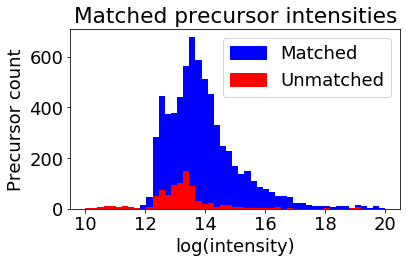

In [34]:
out_file = os.path.join(base_dir, 'results', 'topN_matched_intensities.png')
plot_matched_intensities(matched_intensities, unmatched_intensities, out_file)

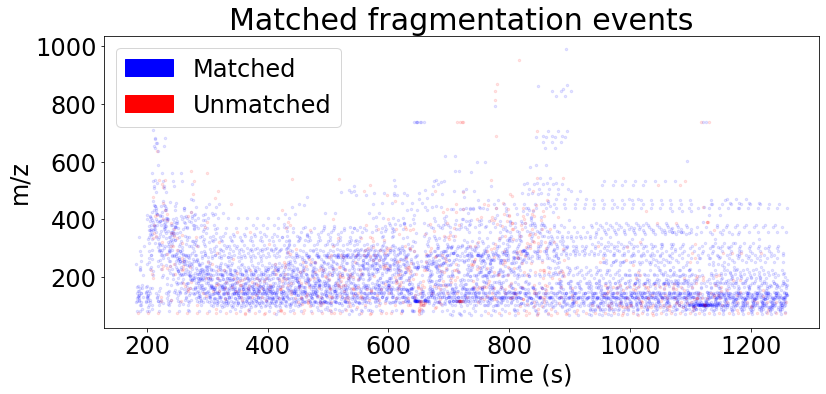

In [35]:
out_file = os.path.join(base_dir, 'results', 'topN_matched_precursors.png')
plot_matched_precursors(matches, 50, 1000, 180, 1260, out_file)